[*********************100%***********************]  1 of 1 completed
C:\Users\mahaj\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Linear Regression Evaluation:
 - RMSE: $2,547.39
 - MAE:  $1,973.65
 - R² Score: 0.9739

Random Forest Evaluation:
 - RMSE: $18,845.62
 - MAE:  $13,307.80
 - R² Score: -0.4295

XGBoost Evaluation:
 - RMSE: $18,189.55
 - MAE:  $12,807.67
 - R² Score: -0.3317


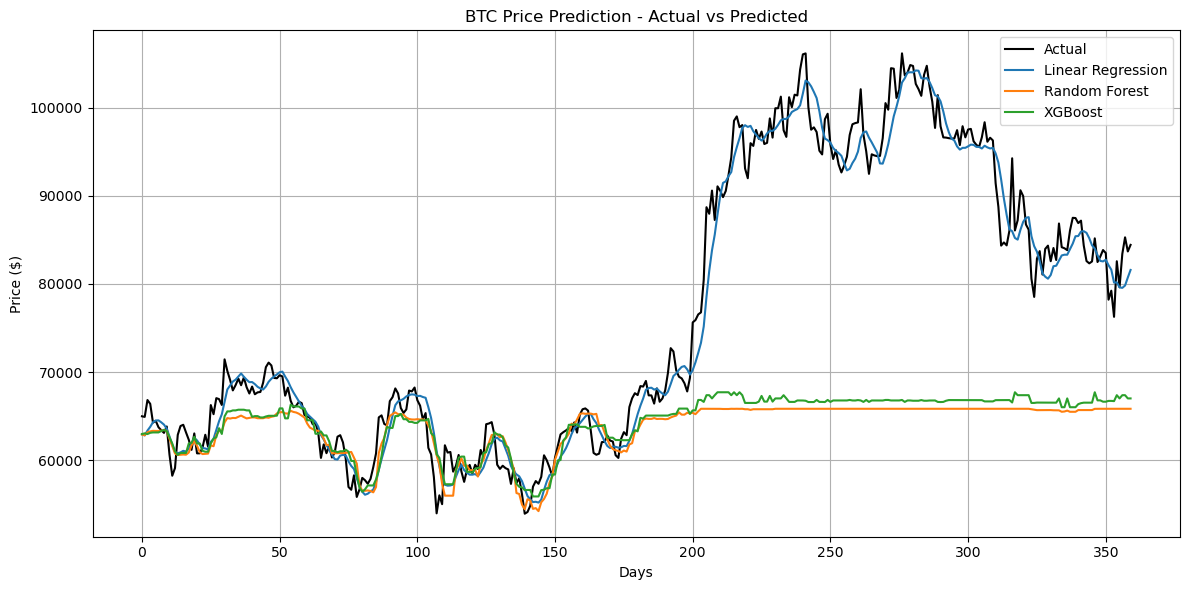


✅ Best model saved: Linear Regression


In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib


df = yf.download("BTC-USD", period="5y", interval="1d")[['Close']].dropna()
df['Returns'] = df['Close'].pct_change()
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Returns'].rolling(window=30).std()


df.dropna(inplace=True)


df['Days'] = np.arange(len(df))
features = ['Days', 'SMA_7', 'SMA_30', 'Volatility']
target = 'Close'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "model": model,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

    print(f"\n{name} Evaluation:")
    print(f" - RMSE: ${rmse:,.2f}")
    print(f" - MAE:  ${mae:,.2f}")
    print(f" - R² Score: {r2:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color='black')

for name in models:
    y_pred = results[name]['model'].predict(X_test)
    plt.plot(y_pred, label=name)

plt.title("BTC Price Prediction - Actual vs Predicted")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


best_model_name = max(results, key=lambda k: results[k]["R2"])
best_model = results[best_model_name]["model"]
joblib.dump(best_model, "btc_model.pkl")
joblib.dump(df, "btc_dataset.pkl")

print(f"\n✅ Best model saved: {best_model_name}")
